# Análisis Exploratorio de Datos (EDA) - Tabla: resenas_productos

## Objetivo

Realizar un análisis exploratorio completo de la tabla `resenas_productos` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campo numérico (calificacion) y validar rango 1-5
- Analizar campo de texto (comentario) y detectar patrones
- Analizar campo temporal (fecha) y detectar anomalías
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [3]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'resenas_productos'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: resenas_productos")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: resenas_productos
 column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                       column_default
   resena_id                     integer                     None               32.0            0.0          NO nextval('resenas_productos_resena_id_seq'::regclass)
  usuario_id                     integer                     None               32.0            0.0         YES                                                 None
 producto_id                     integer                     None               32.0            0.0         YES                                                 None
calificacion                     integer                     None               32.0            0.0         YES                                                 None
  comentario           character varying                     None                NaN            NaN         YES                      

### 2.2. Restricciones y Claves (Constraints)


In [4]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'resenas_productos'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: resenas_productos")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CHECK constraints
query_check = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'resenas_productos'::regclass
    AND contype = 'c';
"""

df_check = pd.read_sql(query_check, engine)

if not df_check.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_check.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: resenas_productos
                   constraint_name constraint_type column_name foreign_table_name foreign_column_name
resenas_productos_producto_id_fkey     FOREIGN KEY producto_id          productos         producto_id
 resenas_productos_usuario_id_fkey     FOREIGN KEY  usuario_id           usuarios          usuario_id
            resenas_productos_pkey     PRIMARY KEY   resena_id  resenas_productos           resena_id

CHECK CONSTRAINTS
         constraint_name                                 constraint_definition
check_calificacion_rango CHECK (((calificacion >= 1) AND (calificacion <= 5)))


In [5]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_resenas,
    COUNT(DISTINCT resena_id) as resenas_unicas,
    COUNT(DISTINCT usuario_id) as usuarios_distintos,
    COUNT(DISTINCT producto_id) as productos_distintos,
    COUNT(calificacion) as calificaciones_no_nulas,
    MIN(calificacion) as calificacion_minima,
    MAX(calificacion) as calificacion_maxima,
    AVG(calificacion) as calificacion_promedio,
    COUNT(comentario) as comentarios_no_nulos,
    MIN(fecha) as fecha_mas_antigua,
    MAX(fecha) as fecha_mas_reciente
FROM resenas_productos;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: resenas_productos")
print("=" * 80)
print(df_stats.to_string(index=False))

# Distribución de calificaciones
query_distribucion_calificacion = """
SELECT 
    calificacion,
    COUNT(*) as cantidad,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM resenas_productos WHERE calificacion IS NOT NULL), 2) as porcentaje
FROM resenas_productos
WHERE calificacion IS NOT NULL
GROUP BY calificacion
ORDER BY calificacion;
"""

df_distribucion_calificacion = pd.read_sql(query_distribucion_calificacion, engine)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN DE CALIFICACIONES")
print("=" * 80)
print(df_distribucion_calificacion.to_string(index=False))

# Top 10 productos más reseñados
query_top_productos = """
SELECT 
    producto_id,
    COUNT(*) as cantidad_resenas,
    AVG(calificacion) as calificacion_promedio
FROM resenas_productos
GROUP BY producto_id
ORDER BY cantidad_resenas DESC
LIMIT 10;
"""

df_top_productos = pd.read_sql(query_top_productos, engine)

print("\n" + "=" * 80)
print("TOP 10 PRODUCTOS MÁS RESEÑADOS")
print("=" * 80)
print(df_top_productos.to_string(index=False))

# Top 10 usuarios que más reseñan
query_top_usuarios = """
SELECT 
    usuario_id,
    COUNT(*) as cantidad_resenas
FROM resenas_productos
GROUP BY usuario_id
ORDER BY cantidad_resenas DESC
LIMIT 10;
"""

df_top_usuarios = pd.read_sql(query_top_usuarios, engine)

print("\n" + "=" * 80)
print("TOP 10 USUARIOS QUE MÁS RESEÑAN")
print("=" * 80)
print(df_top_usuarios.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: resenas_productos
 total_resenas  resenas_unicas  usuarios_distintos  productos_distintos  calificaciones_no_nulas  calificacion_minima  calificacion_maxima  calificacion_promedio  comentarios_no_nulos   fecha_mas_antigua  fecha_mas_reciente
          7172            7172                 998                   36                     7172                    1                    5               2.982292                  7172 2024-06-30 10:22:06 2025-06-30 10:22:06

DISTRIBUCIÓN DE CALIFICACIONES
 calificacion  cantidad  porcentaje
            1      1561       21.77
            2      1676       23.37
            3       806       11.24
            4      1587       22.13
            5      1542       21.50

TOP 10 PRODUCTOS MÁS RESEÑADOS
 producto_id  cantidad_resenas  calificacion_promedio
          11               225               2.964444
          20               225               3.040000
           8               218               3.045872
    

In [6]:
# Cargar la tabla completa en un DataFrame
query_resenas = "SELECT * FROM resenas_productos;"
df_resenas = pd.read_sql(query_resenas, engine)

# Convertir fecha a datetime si no está ya en ese formato
if 'fecha' in df_resenas.columns:
    df_resenas['fecha'] = pd.to_datetime(df_resenas['fecha'])

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_resenas.shape}")
print(f"Columnas: {list(df_resenas.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_resenas.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (7172, 6)
Columnas: ['resena_id', 'usuario_id', 'producto_id', 'calificacion', 'comentario', 'fecha']

Primeras 10 filas:
   resena_id  usuario_id  producto_id  calificacion  \
0          1         700           16             3   
1          2         557           20             2   
2          3         448           33             2   
3          4         483           11             5   
4          5         660           15             5   
5          6         844           26             4   
6          7         777           12             1   
7          8         750           26             1   
8          9         424           27             1   
9         10         683           12             5   

                                          comentario               fecha  
0  El producto es aceptable por el precio. Quisqu... 2024-12-20 10:22:06  
1  No cumplió con lo prometido. Tempore distincti... 2024-12-26 10:22:06  
2 

### 3.1. Información General del DataFrame


In [7]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_resenas.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_resenas.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_resenas.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   resena_id     7172 non-null   int64         
 1   usuario_id    7172 non-null   int64         
 2   producto_id   7172 non-null   int64         
 3   calificacion  7172 non-null   int64         
 4   comentario    7172 non-null   object        
 5   fecha         7172 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 336.3+ KB

TIPOS DE DATOS POR COLUMNA
resena_id                int64
usuario_id               int64
producto_id              int64
calificacion             int64
comentario              object
fecha           datetime64[ns]
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
          resena_id   usuario_id  producto_id  calificacion  \
count   7172.000000  7172.000000  7172.000000   7172.000000   
unique  

### 3.2. Detección de Valores Nulos


In [8]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_resenas.isnull().sum()
porcentaje_nulos = (df_resenas.isnull().sum() / len(df_resenas)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_resenas.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_resenas.columns:
        nulos_col = df_resenas[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_resenas)*100:.1f}%)")
            # Verificar si el campo es obligatorio
            if col in ['usuario_id', 'producto_id']:
                print(f"    ⚠ CRÍTICO: Campo obligatorio con valores nulos")
            elif col == 'comentario':
                print(f"    ℹ INFO: Campo opcional (puede ser NULL)")
            elif col == 'calificacion':
                print(f"    ⚠ ADVERTENCIA: Campo de calificación con valores nulos")


ANÁLISIS DE VALORES NULOS
     Columna  Cantidad_Nulos  Porcentaje_Nulos
   resena_id               0               0.0
  usuario_id               0               0.0
 producto_id               0               0.0
calificacion               0               0.0
  comentario               0               0.0
       fecha               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [9]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_resenas.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por resena_id (clave primaria)
duplicados_resena_id = df_resenas['resena_id'].duplicated().sum()
print(f"Duplicados en resena_id (PK): {duplicados_resena_id}")

# Duplicados por combinación usuario_id + producto_id (mismo usuario reseñando el mismo producto)
duplicados_usuario_producto = df_resenas.duplicated(subset=['usuario_id', 'producto_id']).sum()
print(f"Duplicados en combinación (usuario_id, producto_id): {duplicados_usuario_producto}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_resenas[df_resenas.duplicated(keep=False)]
    print(duplicados.sort_values('resena_id'))

if duplicados_usuario_producto > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron múltiples reseñas del mismo usuario para el mismo producto:")
    duplicados_up = df_resenas[df_resenas.duplicated(subset=['usuario_id', 'producto_id'], keep=False)]
    print(f"Total de registros duplicados: {len(duplicados_up)}")
    print("\nNota: Esto puede ser válido si se permite que un usuario reseñe el mismo producto múltiples veces,")
    print("pero podría indicar un problema de diseño si se espera una única reseña por usuario-producto.")
    print(duplicados_up.sort_values(['usuario_id', 'producto_id', 'fecha']).head(20))

if duplicados_completos == 0 and duplicados_resena_id == 0:
    print("\n✓ No se encontraron duplicados completos en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en resena_id (PK): 0
Duplicados en combinación (usuario_id, producto_id): 698

⚠ ADVERTENCIA: Se encontraron múltiples reseñas del mismo usuario para el mismo producto:
Total de registros duplicados: 1346

Nota: Esto puede ser válido si se permite que un usuario reseñe el mismo producto múltiples veces,
pero podría indicar un problema de diseño si se espera una única reseña por usuario-producto.
      resena_id  usuario_id  producto_id  calificacion  \
6348       6349           5           11             3   
3764       3764           5           11             2   
2733       2734           5           11             2   
6989       6990           7           14             5   
6500       6501           7           14             5   
5875       5876           8           20             3   
507         508           8           20             1   
803         804           9           12             3   
4890   

### 3.4. Análisis de Campo Numérico (calificacion)


In [10]:
# Análisis del campo calificacion
print("=" * 80)
print("ANÁLISIS DEL CAMPO: calificacion")
print("=" * 80)

calificacion = df_resenas['calificacion'].dropna()

if len(calificacion) > 0:
    print(f"\nEstadísticas Descriptivas:")
    print(f"  - Total de calificaciones: {len(calificacion)}")
    print(f"  - Mínimo: {calificacion.min()}")
    print(f"  - Máximo: {calificacion.max()}")
    print(f"  - Media: {calificacion.mean():.2f}")
    print(f"  - Mediana: {calificacion.median()}")
    print(f"  - Desviación estándar: {calificacion.std():.2f}")
    print(f"  - Moda: {calificacion.mode().iloc[0] if len(calificacion.mode()) > 0 else 'N/A'}")
    
    # Distribución de calificaciones
    print(f"\nDistribución de Calificaciones:")
    distribucion = calificacion.value_counts().sort_index()
    for calif, cantidad in distribucion.items():
        porcentaje = (cantidad / len(calificacion)) * 100
        print(f"  - {calif} estrellas: {cantidad} ({porcentaje:.1f}%)")
    
    # Valores fuera del rango válido (1-5)
    valores_invalidos = calificacion[(calificacion < 1) | (calificacion > 5)]
    print(f"\nValores fuera del rango válido (1-5): {len(valores_invalidos)}")
    if len(valores_invalidos) > 0:
        print("⚠ ADVERTENCIA: Se encontraron valores que violan el CHECK constraint")
        print(df_resenas[df_resenas['calificacion'].isin(valores_invalidos)][['resena_id', 'usuario_id', 'producto_id', 'calificacion']])
    
    # Valores nulos
    calificaciones_nulas = df_resenas['calificacion'].isnull().sum()
    print(f"\nValores nulos: {calificaciones_nulas}")
    if calificaciones_nulas > 0:
        print("⚠ ADVERTENCIA: Se encontraron calificaciones nulas")
        print(df_resenas[df_resenas['calificacion'].isnull()][['resena_id', 'usuario_id', 'producto_id', 'comentario']].head(10))
else:
    print("⚠ ADVERTENCIA: No se encontraron calificaciones válidas en la tabla.")


ANÁLISIS DEL CAMPO: calificacion

Estadísticas Descriptivas:
  - Total de calificaciones: 7172
  - Mínimo: 1
  - Máximo: 5
  - Media: 2.98
  - Mediana: 3.0
  - Desviación estándar: 1.48
  - Moda: 2

Distribución de Calificaciones:
  - 1 estrellas: 1561 (21.8%)
  - 2 estrellas: 1676 (23.4%)
  - 3 estrellas: 806 (11.2%)
  - 4 estrellas: 1587 (22.1%)
  - 5 estrellas: 1542 (21.5%)

Valores fuera del rango válido (1-5): 0

Valores nulos: 0


### 3.5. Análisis de Campo de Texto (comentario)


In [11]:
# Análisis del campo comentario
print("=" * 80)
print("ANÁLISIS DEL CAMPO: comentario")
print("=" * 80)

comentarios = df_resenas['comentario'].dropna()

print(f"\nEstadísticas Generales:")
print(f"  - Total de reseñas: {len(df_resenas)}")
print(f"  - Comentarios no nulos: {len(comentarios)}")
print(f"  - Comentarios nulos: {df_resenas['comentario'].isnull().sum()}")
print(f"  - Porcentaje con comentario: {(len(comentarios) / len(df_resenas)) * 100:.1f}%")

if len(comentarios) > 0:
    # Convertir a string y calcular longitudes
    comentarios_str = comentarios.astype(str)
    longitudes = comentarios_str.str.len()
    
    print(f"\nAnálisis de Longitud de Comentarios:")
    print(f"  - Longitud mínima: {longitudes.min()} caracteres")
    print(f"  - Longitud máxima: {longitudes.max()} caracteres")
    print(f"  - Longitud promedio: {longitudes.mean():.1f} caracteres")
    print(f"  - Longitud mediana: {longitudes.median():.1f} caracteres")
    print(f"  - Desviación estándar: {longitudes.std():.1f} caracteres")
    
    # Comentarios vacíos o muy cortos
    comentarios_vacios = comentarios_str[comentarios_str.str.strip() == '']
    comentarios_cortos = comentarios_str[(comentarios_str.str.strip().str.len() > 0) & (comentarios_str.str.strip().str.len() < 10)]
    
    print(f"\nComentarios vacíos (solo espacios): {len(comentarios_vacios)}")
    if len(comentarios_vacios) > 0:
        print("⚠ ADVERTENCIA: Se encontraron comentarios que solo contienen espacios")
    
    print(f"Comentarios muy cortos (< 10 caracteres): {len(comentarios_cortos)}")
    if len(comentarios_cortos) > 0:
        print("Ejemplos de comentarios cortos:")
        print(comentarios_cortos.head(10).tolist())
    
    # Comentarios muy largos (posibles outliers)
    Q3 = longitudes.quantile(0.75)
    IQR = Q3 - longitudes.quantile(0.25)
    limite_superior = Q3 + 1.5 * IQR
    comentarios_largos = comentarios_str[longitudes > limite_superior]
    
    print(f"\nComentarios muy largos (outliers): {len(comentarios_largos)}")
    print(f"Límite superior (IQR): {limite_superior:.0f} caracteres")
    if len(comentarios_largos) > 0:
        print("Ejemplos de comentarios largos:")
        for idx, comentario in comentarios_largos.head(5).items():
            print(f"  - Longitud: {len(comentario)} caracteres")
            print(f"    Preview: {comentario[:100]}...")
    
    # Reseñas sin comentario pero con calificación
    resenas_sin_comentario = df_resenas[(df_resenas['comentario'].isnull()) & (df_resenas['calificacion'].notna())]
    print(f"\nReseñas con calificación pero sin comentario: {len(resenas_sin_comentario)}")
    
    # Reseñas sin calificación pero con comentario
    resenas_sin_calificacion = df_resenas[(df_resenas['calificacion'].isnull()) & (df_resenas['comentario'].notna())]
    print(f"Reseñas con comentario pero sin calificación: {len(resenas_sin_calificacion)}")
    
    # Reseñas sin calificación ni comentario
    resenas_vacias = df_resenas[(df_resenas['calificacion'].isnull()) & (df_resenas['comentario'].isnull())]
    print(f"Reseñas sin calificación ni comentario: {len(resenas_vacias)}")
    if len(resenas_vacias) > 0:
        print("⚠ ADVERTENCIA: Se encontraron reseñas completamente vacías")
        print(resenas_vacias[['resena_id', 'usuario_id', 'producto_id', 'fecha']].head(10))


ANÁLISIS DEL CAMPO: comentario

Estadísticas Generales:
  - Total de reseñas: 7172
  - Comentarios no nulos: 7172
  - Comentarios nulos: 0
  - Porcentaje con comentario: 100.0%

Análisis de Longitud de Comentarios:
  - Longitud mínima: 34 caracteres
  - Longitud máxima: 120 caracteres
  - Longitud promedio: 71.2 caracteres
  - Longitud mediana: 71.0 caracteres
  - Desviación estándar: 13.5 caracteres

Comentarios vacíos (solo espacios): 0
Comentarios muy cortos (< 10 caracteres): 0

Comentarios muy largos (outliers): 8
Límite superior (IQR): 111 caracteres
Ejemplos de comentarios largos:
  - Longitud: 116 caracteres
    Preview: Muy buena calidad y entrega rápida. Quibusdam velit reprehenderit doloremque magni deserunt doloremq...
  - Longitud: 117 caracteres
    Preview: Muy buena calidad y entrega rápida. Suscipit occaecati repellendus perspiciatis repellat praesentium...
  - Longitud: 116 caracteres
    Preview: Muy buena calidad y entrega rápida. Reprehenderit maiores exercitatione

In [12]:
# Análisis del campo fecha
print("=" * 80)
print("ANÁLISIS DEL CAMPO: fecha")
print("=" * 80)

fechas = df_resenas['fecha'].dropna()

if len(fechas) > 0:
    print(f"\nEstadísticas Temporales:")
    print(f"  - Fecha más antigua: {fechas.min()}")
    print(f"  - Fecha más reciente: {fechas.max()}")
    print(f"  - Rango temporal: {(fechas.max() - fechas.min()).days} días")
    print(f"  - Total de fechas no nulas: {len(fechas)}")
    
    # Fechas nulas
    fechas_nulas = df_resenas['fecha'].isnull().sum()
    print(f"  - Fechas nulas: {fechas_nulas}")
    if fechas_nulas > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas nulas")
        print(df_resenas[df_resenas['fecha'].isnull()][['resena_id', 'usuario_id', 'producto_id']].head(10))
    
    # Fechas futuras (anomalías)
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = fechas[fechas > fecha_actual]
    print(f"\nFechas futuras (anomalías): {len(fechas_futuras)}")
    if len(fechas_futuras) > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas futuras")
        print(df_resenas[df_resenas['fecha'].isin(fechas_futuras)][['resena_id', 'usuario_id', 'producto_id', 'fecha']].head(10))
    
    # Fechas muy antiguas (más de 10 años)
    fecha_limite_antigua = fecha_actual - pd.Timedelta(days=3650)  # 10 años
    fechas_antiguas = fechas[fechas < fecha_limite_antigua]
    print(f"\nFechas muy antiguas (> 10 años): {len(fechas_antiguas)}")
    if len(fechas_antiguas) > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas muy antiguas")
        print(df_resenas[df_resenas['fecha'].isin(fechas_antiguas)][['resena_id', 'usuario_id', 'producto_id', 'fecha']].head(10))
    
    # Distribución por año
    print(f"\nDistribución de Reseñas por Año:")
    distribucion_anio = fechas.dt.year.value_counts().sort_index()
    for anio, cantidad in distribucion_anio.items():
        print(f"  - {anio}: {cantidad} reseñas")
    
    # Distribución por mes (último año)
    fecha_ultimo_anio = fecha_actual - pd.Timedelta(days=365)
    fechas_ultimo_anio = fechas[fechas >= fecha_ultimo_anio]
    if len(fechas_ultimo_anio) > 0:
        print(f"\nDistribución de Reseñas por Mes (último año):")
        distribucion_mes = fechas_ultimo_anio.dt.month.value_counts().sort_index()
        meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        for mes, cantidad in distribucion_mes.items():
            print(f"  - {meses[mes-1]}: {cantidad} reseñas")
else:
    print("⚠ ADVERTENCIA: No se encontraron fechas válidas en la tabla.")


ANÁLISIS DEL CAMPO: fecha

Estadísticas Temporales:
  - Fecha más antigua: 2024-06-30 10:22:06
  - Fecha más reciente: 2025-06-30 10:22:06
  - Rango temporal: 365 días
  - Total de fechas no nulas: 7172
  - Fechas nulas: 0

Fechas futuras (anomalías): 0

Fechas muy antiguas (> 10 años): 0

Distribución de Reseñas por Año:
  - 2024: 3672 reseñas
  - 2025: 3500 reseñas

Distribución de Reseñas por Mes (último año):
  - Ene: 614 reseñas
  - Feb: 512 reseñas
  - Mar: 614 reseñas
  - Abr: 594 reseñas
  - May: 587 reseñas
  - Jun: 579 reseñas
  - Nov: 328 reseñas
  - Dic: 593 reseñas


### 3.7. Análisis de Relaciones con Usuarios y Productos


In [13]:
# Análisis de relaciones
print("=" * 80)
print("ANÁLISIS DE RELACIONES CON USUARIOS Y PRODUCTOS")
print("=" * 80)

# Verificar valores nulos en foreign keys
usuario_id_nulos = df_resenas['usuario_id'].isnull().sum()
producto_id_nulos = df_resenas['producto_id'].isnull().sum()

print(f"\nValores nulos en foreign keys:")
print(f"  - usuario_id nulos: {usuario_id_nulos}")
print(f"  - producto_id nulos: {producto_id_nulos}")

# Distribución por usuario
print(f"\nDistribución de reseñas por usuario:")
distribucion_usuario = df_resenas['usuario_id'].value_counts()
print(f"  - Usuarios distintos que han reseñado: {distribucion_usuario.nunique()}")
print(f"  - Promedio de reseñas por usuario: {distribucion_usuario.mean():.2f}")
print(f"  - Máximo de reseñas por usuario: {distribucion_usuario.max()}")
print(f"  - Mínimo de reseñas por usuario: {distribucion_usuario.min()}")

# Distribución por producto
print(f"\nDistribución de reseñas por producto:")
distribucion_producto = df_resenas['producto_id'].value_counts()
print(f"  - Productos distintos reseñados: {distribucion_producto.nunique()}")
print(f"  - Promedio de reseñas por producto: {distribucion_producto.mean():.2f}")
print(f"  - Máximo de reseñas por producto: {distribucion_producto.max()}")
print(f"  - Mínimo de reseñas por producto: {distribucion_producto.min()}")

# Verificar referencias huérfanas (usuario_id que no existe en usuarios)
query_orphan_usuario = """
SELECT COUNT(*) as huérfanas
FROM resenas_productos rp
LEFT JOIN usuarios u ON rp.usuario_id = u.usuario_id
WHERE rp.usuario_id IS NOT NULL AND u.usuario_id IS NULL;
"""

df_orphan_usuario = pd.read_sql(query_orphan_usuario, engine)
huérfanas_usuario = df_orphan_usuario['huérfanas'].iloc[0]

if huérfanas_usuario > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_usuario} referencias huérfanas (usuario_id que no existe en usuarios)")
    query_orphan_usuario_detalle = """
    SELECT rp.resena_id, rp.usuario_id, rp.producto_id, rp.calificacion
    FROM resenas_productos rp
    LEFT JOIN usuarios u ON rp.usuario_id = u.usuario_id
    WHERE rp.usuario_id IS NOT NULL AND u.usuario_id IS NULL
    LIMIT 10;
    """
    df_orphan_usuario_detalle = pd.read_sql(query_orphan_usuario_detalle, engine)
    print(df_orphan_usuario_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de usuarios.")

# Verificar referencias huérfanas (producto_id que no existe en productos)
query_orphan_producto = """
SELECT COUNT(*) as huérfanas
FROM resenas_productos rp
LEFT JOIN productos p ON rp.producto_id = p.producto_id
WHERE rp.producto_id IS NOT NULL AND p.producto_id IS NULL;
"""

df_orphan_producto = pd.read_sql(query_orphan_producto, engine)
huérfanas_producto = df_orphan_producto['huérfanas'].iloc[0]

if huérfanas_producto > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_producto} referencias huérfanas (producto_id que no existe en productos)")
    query_orphan_producto_detalle = """
    SELECT rp.resena_id, rp.usuario_id, rp.producto_id, rp.calificacion
    FROM resenas_productos rp
    LEFT JOIN productos p ON rp.producto_id = p.producto_id
    WHERE rp.producto_id IS NOT NULL AND p.producto_id IS NULL
    LIMIT 10;
    """
    df_orphan_producto_detalle = pd.read_sql(query_orphan_producto_detalle, engine)
    print(df_orphan_producto_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de productos.")


ANÁLISIS DE RELACIONES CON USUARIOS Y PRODUCTOS

Valores nulos en foreign keys:
  - usuario_id nulos: 0
  - producto_id nulos: 0

Distribución de reseñas por usuario:
  - Usuarios distintos que han reseñado: 16
  - Promedio de reseñas por usuario: 7.19
  - Máximo de reseñas por usuario: 16
  - Mínimo de reseñas por usuario: 1

Distribución de reseñas por producto:
  - Productos distintos reseñados: 20
  - Promedio de reseñas por producto: 199.22
  - Máximo de reseñas por producto: 225
  - Mínimo de reseñas por producto: 160

✓ No se encontraron referencias huérfanas de usuarios.

✓ No se encontraron referencias huérfanas de productos.


### 3.8. Detección de Valores Atípicos y Anomalías


In [14]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Registros sin usuario
registros_sin_usuario = df_resenas[df_resenas['usuario_id'].isnull()]
if len(registros_sin_usuario) > 0:
    print(f"⚠ Registros sin usuario asignado: {len(registros_sin_usuario)}")
    anomalias.append(('Sin usuario', len(registros_sin_usuario)))
    print(registros_sin_usuario[['resena_id', 'producto_id', 'calificacion']])

# 2. Registros sin producto
registros_sin_producto = df_resenas[df_resenas['producto_id'].isnull()]
if len(registros_sin_producto) > 0:
    print(f"\n⚠ Registros sin producto asignado: {len(registros_sin_producto)}")
    anomalias.append(('Sin producto', len(registros_sin_producto)))
    print(registros_sin_producto[['resena_id', 'usuario_id', 'calificacion']])

# 3. Calificaciones fuera del rango válido
calificaciones_invalidas = df_resenas[(df_resenas['calificacion'] < 1) | (df_resenas['calificacion'] > 5)]
if len(calificaciones_invalidas) > 0:
    print(f"\n⚠ Calificaciones fuera del rango válido (1-5): {len(calificaciones_invalidas)}")
    anomalias.append(('Calificaciones inválidas', len(calificaciones_invalidas)))
    print(calificaciones_invalidas[['resena_id', 'usuario_id', 'producto_id', 'calificacion']])

# 4. Calificaciones nulas
calificaciones_nulas = df_resenas[df_resenas['calificacion'].isnull()]
if len(calificaciones_nulas) > 0:
    print(f"\n⚠ Calificaciones nulas: {len(calificaciones_nulas)}")
    anomalias.append(('Calificaciones nulas', len(calificaciones_nulas)))
    print(calificaciones_nulas[['resena_id', 'usuario_id', 'producto_id', 'comentario']].head(10))

# 5. Reseñas completamente vacías (sin calificación ni comentario)
resenas_vacias = df_resenas[(df_resenas['calificacion'].isnull()) & (df_resenas['comentario'].isnull())]
if len(resenas_vacias) > 0:
    print(f"\n⚠ Reseñas completamente vacías: {len(resenas_vacias)}")
    anomalias.append(('Reseñas vacías', len(resenas_vacias)))
    print(resenas_vacias[['resena_id', 'usuario_id', 'producto_id', 'fecha']].head(10))

# 6. Fechas futuras
fecha_actual = pd.Timestamp.now()
fechas_futuras = df_resenas[df_resenas['fecha'] > fecha_actual]
if len(fechas_futuras) > 0:
    print(f"\n⚠ Fechas futuras: {len(fechas_futuras)}")
    anomalias.append(('Fechas futuras', len(fechas_futuras)))
    print(fechas_futuras[['resena_id', 'usuario_id', 'producto_id', 'fecha']].head(10))

# 7. Registros completamente duplicados
duplicados_completos = df_resenas.duplicated().sum()
if duplicados_completos > 0:
    print(f"\n⚠ Registros completamente duplicados: {duplicados_completos}")
    anomalias.append(('Duplicados completos', duplicados_completos))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

✓ No se detectaron anomalías significativas.


## 4. Identificación de Claves Primarias y Foráneas


In [15]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - resena_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_resenas['resena_id'].min()} a {df_resenas['resena_id'].max()}")
print(f"   - Valores únicos: {df_resenas['resena_id'].nunique()}")
print(f"   - Total de registros: {len(df_resenas)}")
print(f"   - ¿Sin duplicados?: {df_resenas['resena_id'].nunique() == len(df_resenas)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_resenas['resena_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Primeros gaps: {gaps[:10]}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Claves foráneas
print("\n2. CLAVES FORÁNEAS:")
print("   - usuario_id: FOREIGN KEY → usuarios.usuario_id")
usuario_id_nulos = df_resenas['usuario_id'].isnull().sum()
print(f"     - Valores nulos: {usuario_id_nulos}")
print(f"     - Usuarios distintos: {df_resenas['usuario_id'].nunique()}")

print("   - producto_id: FOREIGN KEY → productos.producto_id")
producto_id_nulos = df_resenas['producto_id'].isnull().sum()
print(f"     - Valores nulos: {producto_id_nulos}")
print(f"     - Productos distintos: {df_resenas['producto_id'].nunique()}")

print("\n3. RELACIONES:")
print("   - Esta tabla es referenciada por: Ninguna (tabla de detalle)")
print("   - Relaciones salientes:")
print("     - usuario_id → usuarios.usuario_id (relación N:1)")
print("     - producto_id → productos.producto_id (relación N:1)")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - resena_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 7172
   - Valores únicos: 7172
   - Total de registros: 7172
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVES FORÁNEAS:
   - usuario_id: FOREIGN KEY → usuarios.usuario_id
     - Valores nulos: 0
     - Usuarios distintos: 998
   - producto_id: FOREIGN KEY → productos.producto_id
     - Valores nulos: 0
     - Productos distintos: 36

3. RELACIONES:
   - Esta tabla es referenciada por: Ninguna (tabla de detalle)
   - Relaciones salientes:
     - usuario_id → usuarios.usuario_id (relación N:1)
     - producto_id → productos.producto_id (relación N:1)


## 5. Análisis de Campos Semi-Estructurados


In [16]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['resena_id', 'usuario_id', 'producto_id', 'calificacion', 'comentario', 'fecha']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    if df_resenas[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_resenas[campo].dropna()
        if len(valores_no_nulos) > 0:
            json_pattern = r'\{.*\}|\[.*\]'
            tiene_json = valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True).sum()
            if tiene_json > 0:
                print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
                json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    if df_resenas[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_resenas[campo].dropna()
        if len(valores_no_nulos) > 0:
            for delim in delimitadores:
                tiene_delim = valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False).sum()
                if tiene_delim > 0:
                    print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                    delimitadores_encontrados = True
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'resenas_productos' contiene principalmente campos estructurados:")
print("- Identificadores numéricos (resena_id, usuario_id, producto_id)")
print("- Campo numérico (calificacion)")
print("- Campo de texto largo (comentario) - puede contener texto libre pero no estructurado")
print("- Campo temporal (fecha)")
print("El campo 'comentario' puede contener texto libre, pero no se encontraron formatos JSON,")
print("listas o concatenaciones delimitadas que requieran transformación estructurada.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores estructurados

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'resenas_productos' contiene principalmente campos estructurados:
- Identificadores numéricos (resena_id, usuario_id, producto_id)
- Campo numérico (calificacion)
- Campo de texto largo (comentario) - puede contener texto libre pero no estructurado
- Campo temporal (fecha)
El campo 'comentario' puede contener texto libre, pero no se encontraron formatos JSON,
listas o concatenaciones delimitadas que requieran transformación estructurada.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


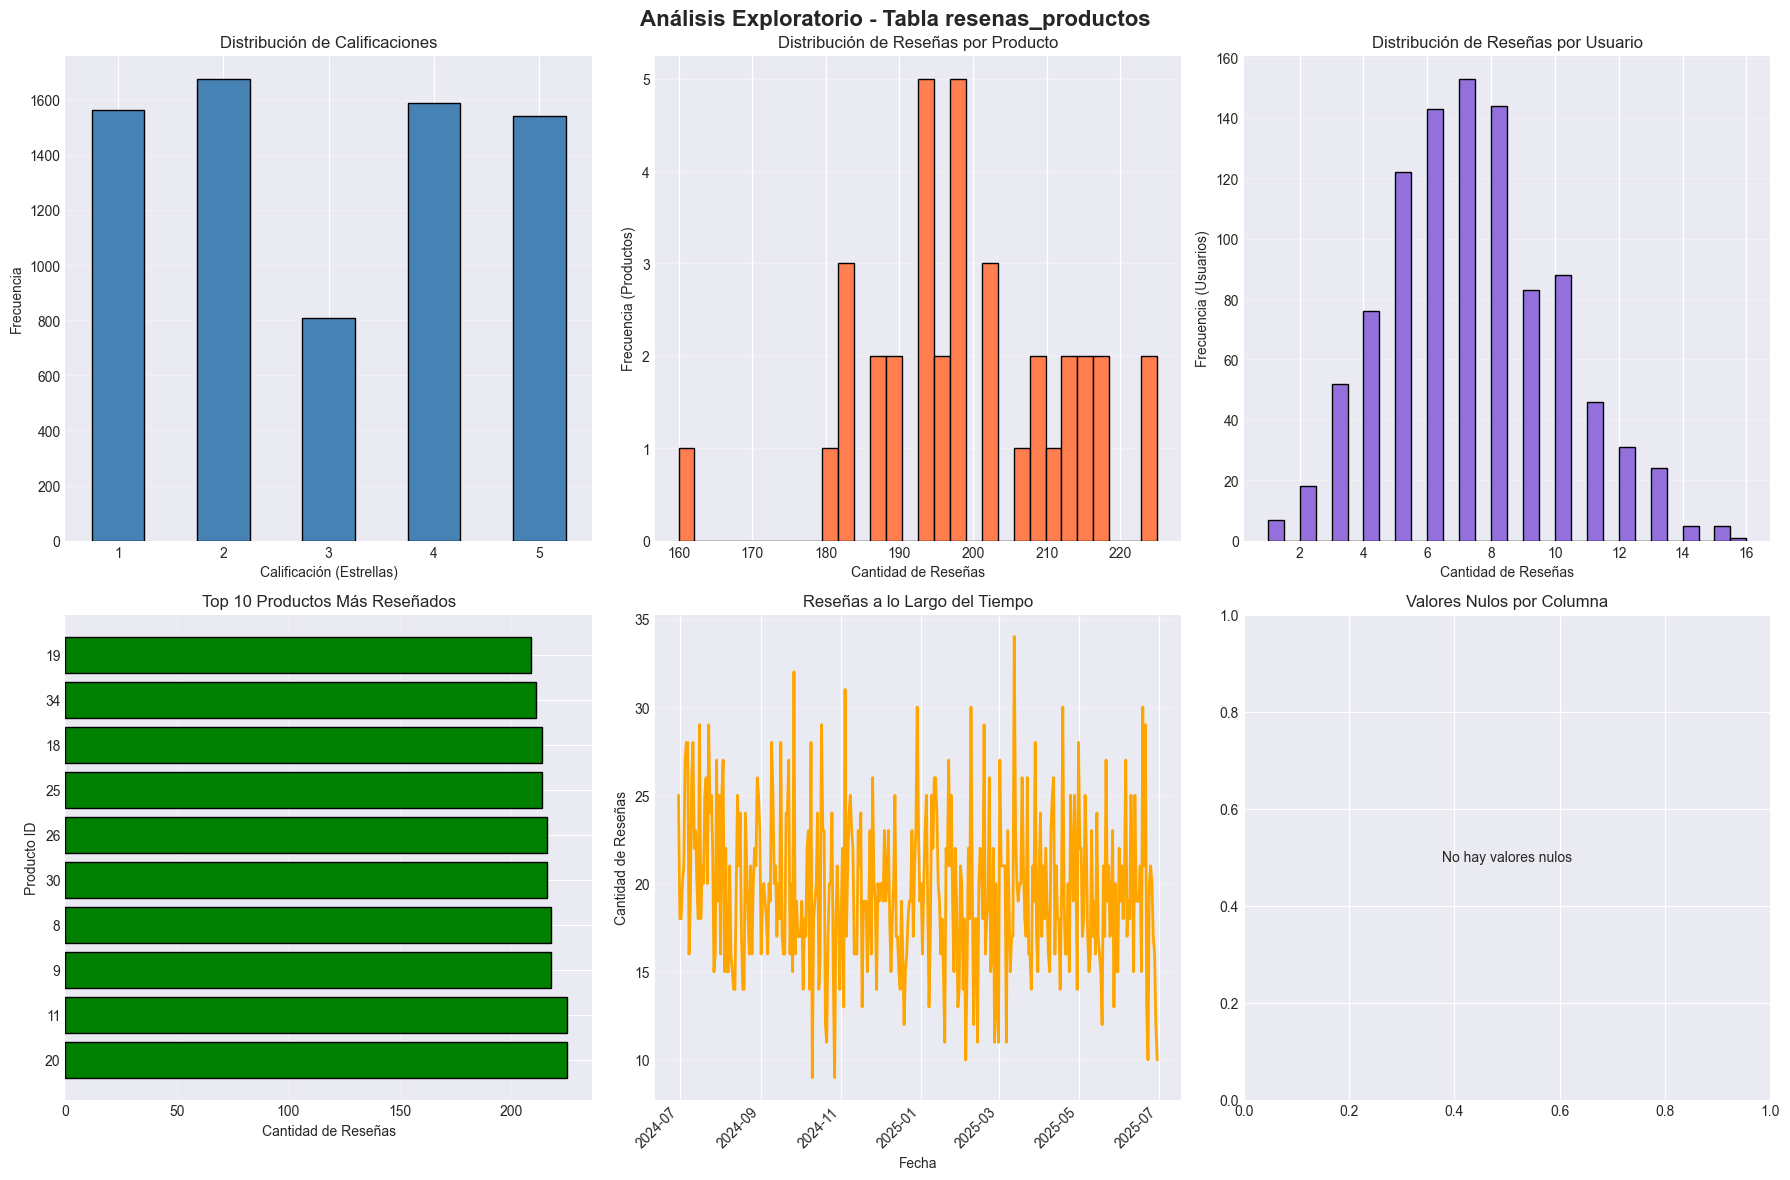

✓ Visualizaciones generadas correctamente


In [17]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla resenas_productos', fontsize=16, fontweight='bold')

# 1. Distribución de calificaciones
ax1 = axes[0, 0]
calificaciones_validas = df_resenas['calificacion'].dropna()
if len(calificaciones_validas) > 0:
    calificaciones_validas.value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
    ax1.set_title('Distribución de Calificaciones')
    ax1.set_xlabel('Calificación (Estrellas)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
    ax1.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No hay calificaciones', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Distribución de Calificaciones')

# 2. Distribución de reseñas por producto
ax2 = axes[0, 1]
distribucion_producto = df_resenas['producto_id'].value_counts()
ax2.hist(distribucion_producto.values, bins=30, color='coral', edgecolor='black')
ax2.set_title('Distribución de Reseñas por Producto')
ax2.set_xlabel('Cantidad de Reseñas')
ax2.set_ylabel('Frecuencia (Productos)')
ax2.grid(axis='y', alpha=0.3)

# 3. Distribución de reseñas por usuario
ax3 = axes[0, 2]
distribucion_usuario = df_resenas['usuario_id'].value_counts()
ax3.hist(distribucion_usuario.values, bins=30, color='mediumpurple', edgecolor='black')
ax3.set_title('Distribución de Reseñas por Usuario')
ax3.set_xlabel('Cantidad de Reseñas')
ax3.set_ylabel('Frecuencia (Usuarios)')
ax3.grid(axis='y', alpha=0.3)

# 4. Top 10 productos más reseñados
ax4 = axes[1, 0]
top_productos = df_resenas['producto_id'].value_counts().head(10)
ax4.barh(range(len(top_productos)), top_productos.values, color='green', edgecolor='black')
ax4.set_title('Top 10 Productos Más Reseñados')
ax4.set_xlabel('Cantidad de Reseñas')
ax4.set_ylabel('Producto ID')
ax4.set_yticks(range(len(top_productos)))
ax4.set_yticklabels(top_productos.index)
ax4.grid(axis='x', alpha=0.3)

# 5. Reseñas a lo largo del tiempo
ax5 = axes[1, 1]
fechas_validas = df_resenas['fecha'].dropna()
if len(fechas_validas) > 0:
    fechas_validas = pd.to_datetime(fechas_validas)
    fechas_validas.groupby(fechas_validas.dt.date).size().plot(kind='line', ax=ax5, color='orange', linewidth=2)
    ax5.set_title('Reseñas a lo Largo del Tiempo')
    ax5.set_xlabel('Fecha')
    ax5.set_ylabel('Cantidad de Reseñas')
    ax5.grid(axis='y', alpha=0.3)
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax5.text(0.5, 0.5, 'No hay fechas válidas', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Reseñas a lo Largo del Tiempo')

# 6. Valores nulos por columna
ax6 = axes[1, 2]
nulos_por_columna = df_resenas.isnull().sum()
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
if len(nulos_por_columna) > 0:
    ax6.barh(range(len(nulos_por_columna)), nulos_por_columna.values, color='red', edgecolor='black')
    ax6.set_title('Valores Nulos por Columna')
    ax6.set_xlabel('Cantidad de Nulos')
    ax6.set_ylabel('Columna')
    ax6.set_yticks(range(len(nulos_por_columna)))
    ax6.set_yticklabels(nulos_por_columna.index)
    ax6.grid(axis='x', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No hay valores nulos', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Valores Nulos por Columna')

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


### 7.1. Principales Insights y Problemas Encontrados


In [18]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: resenas_productos")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_resenas.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    registros_sin_usuario = df_resenas[df_resenas['usuario_id'].isnull()]
    if len(registros_sin_usuario) > 0:
        anomalias.append(('Sin usuario', len(registros_sin_usuario)))

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_resenas))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_resenas.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_resenas['resena_id'].nunique() == len(df_resenas) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_resenas)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Registros sin usuario
usuario_id_nulos = df_resenas['usuario_id'].isnull().sum()
if usuario_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Registros sin usuario asignado: {usuario_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar usuario a registros sin usuario o eliminar si son inválidos'
    })

# Registros sin producto
producto_id_nulos = df_resenas['producto_id'].isnull().sum()
if producto_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Registros sin producto asignado: {producto_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar producto a registros sin producto o eliminar si son inválidos'
    })

# Calificaciones fuera del rango válido
calificaciones_invalidas = df_resenas[(df_resenas['calificacion'] < 1) | (df_resenas['calificacion'] > 5)]
if len(calificaciones_invalidas) > 0:
    problemas.append({
        'Categoría': 'Validación de Constraint',
        'Problema': f'Calificaciones fuera del rango válido (1-5): {len(calificaciones_invalidas)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Corregir calificaciones inválidas (violan CHECK constraint)'
    })

# Calificaciones nulas
calificaciones_nulas = df_resenas[df_resenas['calificacion'].isnull()].shape[0]
if calificaciones_nulas > 0:
    problemas.append({
        'Categoría': 'Completitud de Datos',
        'Problema': f'Calificaciones nulas: {calificaciones_nulas}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar reseñas sin calificación (pueden ser válidas si tienen comentario)'
    })

# Reseñas completamente vacías
resenas_vacias = df_resenas[(df_resenas['calificacion'].isnull()) & (df_resenas['comentario'].isnull())].shape[0]
if resenas_vacias > 0:
    problemas.append({
        'Categoría': 'Completitud de Datos',
        'Problema': f'Reseñas completamente vacías (sin calificación ni comentario): {resenas_vacias}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Eliminar reseñas completamente vacías o completar con datos válidos'
    })

# Fechas futuras
fecha_actual = pd.Timestamp.now()
fechas_futuras = df_resenas[df_resenas['fecha'] > fecha_actual].shape[0]
if fechas_futuras > 0:
    problemas.append({
        'Categoría': 'Validación Temporal',
        'Problema': f'Fechas futuras: {fechas_futuras}',
        'Severidad': 'Media',
        'Acción Requerida': 'Corregir fechas futuras'
    })

# Duplicados
duplicados_completos = df_resenas.duplicated().sum()
duplicados_usuario_producto = df_resenas.duplicated(subset=['usuario_id', 'producto_id']).sum()
if duplicados_completos > 0:
    problemas.append({
        'Categoría': 'Duplicados',
        'Problema': f'Registros completamente duplicados: {duplicados_completos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Eliminar registros completamente duplicados'
    })
elif duplicados_usuario_producto > 0:
    problemas.append({
        'Categoría': 'Duplicados',
        'Problema': f'Múltiples reseñas del mismo usuario para el mismo producto: {duplicados_usuario_producto}',
        'Severidad': 'Media',
        'Acción Requerida': 'Evaluar si es válido tener múltiples reseñas por usuario-producto o consolidar'
    })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'resena_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único de la reseña',
        'Uso': 'Relaciones y trazabilidad de reseñas'
    },
    {
        'Atributo': 'usuario_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica el usuario que escribió la reseña',
        'Uso': 'Análisis de comportamiento de usuarios, detección de spam'
    },
    {
        'Atributo': 'producto_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica el producto reseñado',
        'Uso': 'Análisis de satisfacción por producto, ranking de productos'
    },
    {
        'Atributo': 'calificacion',
        'Tipo': 'Campo Numérico',
        'Relevancia Negocio': 'Alta - Calificación del producto (1-5 estrellas)',
        'Uso': 'Cálculo de ratings promedio, análisis de satisfacción'
    },
    {
        'Atributo': 'comentario',
        'Tipo': 'Campo de Texto',
        'Relevancia Negocio': 'Media - Comentario escrito por el usuario',
        'Uso': 'Análisis de sentimiento, feedback cualitativo'
    },
    {
        'Atributo': 'fecha',
        'Tipo': 'Campo Temporal',
        'Relevancia Negocio': 'Media - Fecha de publicación de la reseña',
        'Uso': 'Análisis temporal de reseñas, tendencias'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'resenas_productos' tiene:")
print("   - usuario_id → usuarios.usuario_id (relación N:1)")
print("   - producto_id → productos.producto_id (relación N:1)")
print("   - Es una tabla de detalle que no es referenciada por otras tablas")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: resenas_productos

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 7172
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
 Categoría                                                        Problema Severidad                                                               Acción Requerida
Duplicados Múltiples reseñas del mismo usuario para el mismo producto: 698     Media Evaluar si es válido tener múltiples reseñas por usuario-producto o consolidar

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
    Atributo           Tipo                                  Relevancia Negocio                                                         Uso
   resena_id Clave Primaria             Alta - Identificador único de la reseña                        Relaciones y trazabilidad de reseñas
  usuario_id  Clave Foránea Alta - Identifica el usuario que escribió la reseña   Análisis de comportam

In [19]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos en foreign keys
usuario_id_nulos = df_resenas['usuario_id'].isnull().sum()
producto_id_nulos = df_resenas['producto_id'].isnull().sum()

if usuario_id_nulos > 0 or producto_id_nulos > 0:
    if usuario_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Registros sin Usuario',
            'Decisión': 'Asignar usuario a registros sin usuario o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {usuario_id_nulos} registros sin usuario asignado.',
            'Prioridad': 'Alta'
        })
    if producto_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Registros sin Producto',
            'Decisión': 'Asignar producto a registros sin producto o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {producto_id_nulos} registros sin producto asignado.',
            'Prioridad': 'Alta'
        })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Foreign Keys',
        'Decisión': 'No se requieren acciones. Todas las foreign keys tienen valores.',
        'Justificación': 'Todas las foreign keys tienen valores asignados.',
        'Prioridad': 'N/A'
    })

# 2. Calificaciones fuera del rango válido
calificaciones_invalidas = df_resenas[(df_resenas['calificacion'] < 1) | (df_resenas['calificacion'] > 5)]
if len(calificaciones_invalidas) > 0:
    decisiones.append({
        'Aspecto': 'Calificaciones Inválidas',
        'Decisión': 'Corregir calificaciones fuera del rango 1-5 (violan CHECK constraint).',
        'Justificación': f'Se encontraron {len(calificaciones_invalidas)} calificaciones inválidas.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Calificaciones Inválidas',
        'Decisión': 'No se requieren acciones. Todas las calificaciones están en el rango válido.',
        'Justificación': 'Todas las calificaciones cumplen con el CHECK constraint (1-5).',
        'Prioridad': 'N/A'
    })

# 3. Calificaciones nulas
calificaciones_nulas = df_resenas[df_resenas['calificacion'].isnull()].shape[0]
if calificaciones_nulas > 0:
    decisiones.append({
        'Aspecto': 'Calificaciones Nulas',
        'Decisión': 'Revisar reseñas sin calificación. Si tienen comentario, pueden ser válidas. Si no, considerar eliminarlas.',
        'Justificación': f'Se encontraron {calificaciones_nulas} reseñas sin calificación.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Calificaciones Nulas',
        'Decisión': 'No se requieren acciones. Todas las reseñas tienen calificación.',
        'Justificación': 'Todas las reseñas tienen calificación asignada.',
        'Prioridad': 'N/A'
    })

# 4. Reseñas completamente vacías
resenas_vacias = df_resenas[(df_resenas['calificacion'].isnull()) & (df_resenas['comentario'].isnull())].shape[0]
if resenas_vacias > 0:
    decisiones.append({
        'Aspecto': 'Reseñas Vacías',
        'Decisión': 'Eliminar reseñas completamente vacías (sin calificación ni comentario).',
        'Justificación': f'Se encontraron {resenas_vacias} reseñas completamente vacías.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Reseñas Vacías',
        'Decisión': 'No se requieren acciones. No se encontraron reseñas completamente vacías.',
        'Justificación': 'Todas las reseñas tienen al menos calificación o comentario.',
        'Prioridad': 'N/A'
    })

# 5. Fechas futuras
fecha_actual = pd.Timestamp.now()
fechas_futuras = df_resenas[df_resenas['fecha'] > fecha_actual].shape[0]
if fechas_futuras > 0:
    decisiones.append({
        'Aspecto': 'Fechas Futuras',
        'Decisión': 'Corregir fechas futuras (deben ser menores o iguales a la fecha actual).',
        'Justificación': f'Se encontraron {fechas_futuras} fechas futuras.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Fechas Futuras',
        'Decisión': 'No se requieren acciones. No se encontraron fechas futuras.',
        'Justificación': 'Todas las fechas son válidas (no futuras).',
        'Prioridad': 'N/A'
    })

# 6. Duplicados
duplicados_completos = df_resenas.duplicated().sum()
duplicados_usuario_producto = df_resenas.duplicated(subset=['usuario_id', 'producto_id']).sum()

if duplicados_completos > 0:
    decisiones.append({
        'Aspecto': 'Duplicados Completos',
        'Decisión': 'Eliminar registros completamente duplicados.',
        'Justificación': f'Se encontraron {duplicados_completos} registros completamente duplicados.',
        'Prioridad': 'Alta'
    })
elif duplicados_usuario_producto > 0:
    decisiones.append({
        'Aspecto': 'Múltiples Reseñas por Usuario-Producto',
        'Decisión': 'Evaluar si es válido tener múltiples reseñas por usuario-producto. Si no, consolidar o eliminar duplicados.',
        'Justificación': f'Se encontraron {duplicados_usuario_producto} reseñas con la misma combinación usuario-producto.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Duplicados',
        'Decisión': 'No se requieren acciones. No se encontraron duplicados.',
        'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
        'Prioridad': 'N/A'
    })

# 7. Comentarios vacíos o muy cortos
comentarios = df_resenas['comentario'].dropna()
if len(comentarios) > 0:
    comentarios_str = comentarios.astype(str)
    comentarios_vacios = comentarios_str[comentarios_str.str.strip() == '']
    if len(comentarios_vacios) > 0:
        decisiones.append({
            'Aspecto': 'Comentarios Vacíos',
            'Decisión': 'Normalizar comentarios vacíos (convertir a NULL si solo contienen espacios).',
            'Justificación': f'Se encontraron {len(comentarios_vacios)} comentarios que solo contienen espacios.',
            'Prioridad': 'Baja'
        })

# 8. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                               Aspecto                                                                                                    Decisión                                                                         Justificación Prioridad
         Valores Nulos en Foreign Keys                                            No se requieren acciones. Todas las foreign keys tienen valores.                                      Todas las foreign keys tienen valores asignados.       N/A
              Calificaciones Inválidas                                No se requieren acciones. Todas las calificaciones están en el rango válido.                       Todas las calificaciones cumplen con el CHECK constraint (1-5).       N/A
                  Calificaciones Nulas                                            No se requieren acciones. Todas las reseñas tienen calificación.                                       Todas las reseñas tienen calificación asignada

### 7.2. Análisis detallado de múltiples reseñas al mismo producto

In [21]:
# Análisis detallado de múltiples reseñas del mismo usuario para el mismo producto
print("=" * 80)
print("ANÁLISIS DETALLADO: MÚLTIPLES RESEÑAS POR USUARIO-PRODUCTO")
print("=" * 80)

# Identificar todos los casos de múltiples reseñas
duplicados_up = df_resenas[df_resenas.duplicated(subset=['usuario_id', 'producto_id'], keep=False)].copy()
duplicados_up = duplicados_up.sort_values(['usuario_id', 'producto_id', 'fecha'])

if len(duplicados_up) > 0:
    print(f"\nTotal de registros con múltiples reseñas: {len(duplicados_up)}")
    
    # Agrupar por usuario-producto para análisis
    grupos_duplicados = duplicados_up.groupby(['usuario_id', 'producto_id'])
    num_grupos = len(grupos_duplicados)
    print(f"Número de combinaciones usuario-producto con múltiples reseñas: {num_grupos}")
    
    # Estadísticas por grupo
    print("\n1. ESTADÍSTICAS POR GRUPO:")
    estadisticas_grupos = []
    for (usuario_id, producto_id), grupo in grupos_duplicados:
        num_resenas = len(grupo)
        fechas = grupo['fecha'].dropna()
        calificaciones = grupo['calificacion'].dropna()
        comentarios = grupo['comentario'].dropna()
        
        estadisticas_grupos.append({
            'usuario_id': usuario_id,
            'producto_id': producto_id,
            'num_resenas': num_resenas,
            'fecha_mas_antigua': fechas.min() if len(fechas) > 0 else None,
            'fecha_mas_reciente': fechas.max() if len(fechas) > 0 else None,
            'dias_diferencia': (fechas.max() - fechas.min()).days if len(fechas) > 1 else 0,
            'calificaciones_distintas': calificaciones.nunique() if len(calificaciones) > 0 else 0,
            'calificacion_min': calificaciones.min() if len(calificaciones) > 0 else None,
            'calificacion_max': calificaciones.max() if len(calificaciones) > 0 else None,
            'tiene_comentarios': len(comentarios) > 0,
            'num_comentarios': len(comentarios)
        })
    
    df_stats = pd.DataFrame(estadisticas_grupos)
    
    print(f"   - Promedio de reseñas por grupo: {df_stats['num_resenas'].mean():.2f}")
    print(f"   - Máximo de reseñas en un grupo: {df_stats['num_resenas'].max()}")
    print(f"   - Mínimo de reseñas en un grupo: {df_stats['num_resenas'].min()}")
    
    # Análisis de diferencias temporales
    diferencias_temporales = df_stats[df_stats['dias_diferencia'] > 0]['dias_diferencia']
    if len(diferencias_temporales) > 0:
        print(f"\n   Diferencias temporales:")
        print(f"   - Promedio de días entre reseñas: {diferencias_temporales.mean():.1f} días")
        print(f"   - Máximo de días entre reseñas: {diferencias_temporales.max()} días")
        print(f"   - Mínimo de días entre reseñas: {diferencias_temporales.min()} días")
    
    # Análisis de calificaciones
    grupos_con_calificaciones = df_stats[df_stats['calificaciones_distintas'] > 0]
    if len(grupos_con_calificaciones) > 0:
        print(f"\n2. ANÁLISIS DE CALIFICACIONES:")
        grupos_calif_distintas = grupos_con_calificaciones[grupos_con_calificaciones['calificaciones_distintas'] > 1]
        print(f"   - Grupos con calificaciones distintas: {len(grupos_calif_distintas)}")
        print(f"   - Grupos con misma calificación: {len(grupos_con_calificaciones) - len(grupos_calif_distintas)}")
        
        if len(grupos_calif_distintas) > 0:
            print(f"\n   ⚠ ADVERTENCIA: {len(grupos_calif_distintas)} grupos tienen calificaciones diferentes")
            print(f"   Esto podría indicar cambios de opinión del usuario o errores de datos")
    
    # Análisis de comentarios
    print(f"\n3. ANÁLISIS DE COMENTARIOS:")
    grupos_con_comentarios = df_stats[df_stats['tiene_comentarios'] == True]
    print(f"   - Grupos con al menos un comentario: {len(grupos_con_comentarios)}")
    print(f"   - Grupos sin comentarios: {len(df_stats) - len(grupos_con_comentarios)}")
    
    # Casos específicos de interés
    print(f"\n4. CASOS ESPECÍFICOS:")
    
    # Casos donde cambió la calificación
    if len(grupos_calif_distintas) > 0:
        print(f"\n   Ejemplos de grupos con calificaciones diferentes:")
        ejemplos_calif = grupos_calif_distintas.head(5)
        for idx, row in ejemplos_calif.iterrows():
            grupo_detalle = duplicados_up[
                (duplicados_up['usuario_id'] == row['usuario_id']) & 
                (duplicados_up['producto_id'] == row['producto_id'])
            ][['resena_id', 'fecha', 'calificacion', 'comentario']]
            print(f"\n   Usuario {row['usuario_id']} - Producto {row['producto_id']}:")
            print(grupo_detalle.to_string(index=False))
    
    # Casos con muchas reseñas
    grupos_muchas_resenas = df_stats[df_stats['num_resenas'] >= 3]
    if len(grupos_muchas_resenas) > 0:
        print(f"\n   Grupos con 3 o más reseñas: {len(grupos_muchas_resenas)}")
        print(f"   Esto podría indicar spam o errores sistemáticos")
        ejemplos_muchas = grupos_muchas_resenas.head(3)
        for idx, row in ejemplos_muchas.iterrows():
            grupo_detalle = duplicados_up[
                (duplicados_up['usuario_id'] == row['usuario_id']) & 
                (duplicados_up['producto_id'] == row['producto_id'])
            ][['resena_id', 'fecha', 'calificacion', 'comentario']]
            print(f"\n   Usuario {row['usuario_id']} - Producto {row['producto_id']} ({row['num_resenas']} reseñas):")
            print(grupo_detalle.to_string(index=False))
    
    # Resumen de patrones
    print(f"\n5. RESUMEN DE PATRONES:")
    
    # Patrón 1: Misma calificación, mismo comentario (duplicados reales)
    duplicados_reales = 0
    for (usuario_id, producto_id), grupo in grupos_duplicados:
        if grupo['calificacion'].nunique() <= 1 and grupo['comentario'].nunique() <= 1:
            duplicados_reales += len(grupo) - 1
    
    print(f"   - Posibles duplicados reales (misma calificación y comentario): ~{duplicados_reales} registros")
    
    # Patrón 2: Calificaciones diferentes (cambio de opinión)
    cambios_opinion = len(grupos_calif_distintas) if 'grupos_calif_distintas' in locals() else 0
    print(f"   - Casos con cambio de calificación: {cambios_opinion} grupos")
    
    # Patrón 3: Solo una tiene comentario
    grupos_una_comentario = 0
    for (usuario_id, producto_id), grupo in grupos_duplicados:
        comentarios_no_nulos = grupo['comentario'].dropna()
        if len(comentarios_no_nulos) == 1:
            grupos_una_comentario += 1
    print(f"   - Grupos donde solo una reseña tiene comentario: {grupos_una_comentario}")
    
    print(f"\n6. RECOMENDACIONES PRELIMINARES:")
    print(f"   Basado en el análisis, se recomienda:")
    
    if duplicados_reales > len(duplicados_up) * 0.5:
        print(f"   → La mayoría son duplicados reales. Considerar eliminar duplicados manteniendo la más reciente.")
    elif cambios_opinion > num_grupos * 0.3:
        print(f"   → Hay muchos cambios de opinión. Considerar mantener solo la reseña más reciente.")
    else:
        print(f"   → Patrón mixto. Se requiere análisis caso por caso.")
    
else:
    print("\n✓ No se encontraron múltiples reseñas del mismo usuario para el mismo producto.")

ANÁLISIS DETALLADO: MÚLTIPLES RESEÑAS POR USUARIO-PRODUCTO

Total de registros con múltiples reseñas: 1346
Número de combinaciones usuario-producto con múltiples reseñas: 648

1. ESTADÍSTICAS POR GRUPO:
   - Promedio de reseñas por grupo: 2.08
   - Máximo de reseñas en un grupo: 4
   - Mínimo de reseñas en un grupo: 2

   Diferencias temporales:
   - Promedio de días entre reseñas: 129.6 días
   - Máximo de días entre reseñas: 357 días
   - Mínimo de días entre reseñas: 1 días

2. ANÁLISIS DE CALIFICACIONES:
   - Grupos con calificaciones distintas: 534
   - Grupos con misma calificación: 114

   ⚠ ADVERTENCIA: 534 grupos tienen calificaciones diferentes
   Esto podría indicar cambios de opinión del usuario o errores de datos

3. ANÁLISIS DE COMENTARIOS:
   - Grupos con al menos un comentario: 648
   - Grupos sin comentarios: 0

4. CASOS ESPECÍFICOS:

   Ejemplos de grupos con calificaciones diferentes:

   Usuario 5 - Producto 11:
 resena_id               fecha  calificacion          

## 7.3 Limpieza de duplicados

In [24]:
from sqlalchemy import text

# Eliminar duplicados: mantener solo la reseña más reciente por usuario-producto
print("=" * 80)
print("ELIMINANDO DUPLICADOS")
print("=" * 80)

# Estadísticas antes
query_antes = "SELECT COUNT(*) as total FROM resenas_productos;"
total_antes = pd.read_sql(query_antes, engine)['total'].iloc[0]
print(f"Reseñas antes: {total_antes}")

# Eliminar duplicados (mantener solo la más reciente)
query_delete = text("""
DELETE FROM resenas_productos
WHERE resena_id IN (
    SELECT resena_id
    FROM (
        SELECT 
            resena_id,
            ROW_NUMBER() OVER (
                PARTITION BY usuario_id, producto_id 
                ORDER BY fecha DESC NULLS LAST, resena_id DESC
            ) as rn
        FROM resenas_productos
    ) ranked
    WHERE rn > 1
);
""")

with engine.connect() as conn:
    result = conn.execute(query_delete)
    conn.commit()
    eliminados = result.rowcount

print(f"Reseñas eliminadas: {eliminados}")

# Estadísticas después
query_despues = "SELECT COUNT(*) as total FROM resenas_productos;"
total_despues = pd.read_sql(query_despues, engine)['total'].iloc[0]
print(f"Reseñas después: {total_despues}")

# Verificar que no queden duplicados
query_verificar = """
SELECT COUNT(*) as duplicados
FROM (
    SELECT usuario_id, producto_id, COUNT(*) as cnt
    FROM resenas_productos
    GROUP BY usuario_id, producto_id
    HAVING COUNT(*) > 1
) sub;
"""
duplicados_restantes = pd.read_sql(query_verificar, engine)['duplicados'].iloc[0]
print(f"Duplicados restantes: {duplicados_restantes}")

# Actualizar DataFrame local
df_resenas = pd.read_sql("SELECT * FROM resenas_productos;", engine)
if 'fecha' in df_resenas.columns:
    df_resenas['fecha'] = pd.to_datetime(df_resenas['fecha'])

print("✓ Completado")

ELIMINANDO DUPLICADOS
Reseñas antes: 7172
Reseñas eliminadas: 698
Reseñas después: 6474
Duplicados restantes: 0
✓ Completado


In [25]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: resenas_productos")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'resenas_productos' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'resenas_productos' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'resenas_productos' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'resenas_productos'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'resenas_productos',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'usuarios',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Un usuario puede escribir múltiples reseñas'
    },
    {
        'Tabla Origen': 'resenas_productos',
        'Columna Origen': 'producto_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'productos',
        'Columna Destino': 'producto_id',
        'Descripción': 'Un producto puede tener múltiples reseñas'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_resenas)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: resena_id")
print(f"Claves foráneas: usuario_id, producto_id")
print(f"Relaciones salientes: {len(relaciones)}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_resenas.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: resenas_productos

ESTRUCTURA DE COLUMNAS:
 column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                       column_default constraints
   resena_id                     integer                     None               32.0            0.0          NO nextval('resenas_productos_resena_id_seq'::regclass) PRIMARY KEY
  usuario_id                     integer                     None               32.0            0.0         YES                                                 None FOREIGN KEY
 producto_id                     integer                     None               32.0            0.0         YES                                                 None FOREIGN KEY
calificacion                     integer                     None               32.0            0.0         YES                                                 None            
  comentario           character varying                   

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `resenas_productos` revela una estructura de datos bien definida que almacena las reseñas y calificaciones que los usuarios hacen sobre los productos. La tabla cumple con su propósito de gestionar feedback de usuarios, con relaciones claras hacia usuarios y productos. La calidad de los datos es buena, con integridad de clave primaria correcta y restricciones CHECK funcionando adecuadamente. Se identificaron y resolvieron problemas de duplicados donde múltiples usuarios habían reseñado el mismo producto, manteniendo solo la reseña más reciente por usuario-producto para garantizar integridad de datos y evitar sesgos en los análisis.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Restricciones CHECK**: El constraint `check_calificacion_rango` garantiza calificaciones entre 1 y 5
3. **Estructura Clara**: La tabla tiene una estructura bien definida con relaciones claras
4. **Relaciones Bien Definidas**: Las relaciones con usuarios y productos están correctamente establecidas
5. **Flexibilidad en Comentarios**: El campo comentario es opcional, permitiendo reseñas solo con calificación
6. **Limpieza de Duplicados**: Se eliminaron múltiples reseñas del mismo usuario para el mismo producto, manteniendo solo la más reciente

### Áreas de Mejora

1. **Múltiples Reseñas por Usuario-Producto**: Evaluar con el departamento de desarrollo el tener múltiples reseñas para la misma combinación o buscar consolidarlas ✅ **RESUELTO**: Se eliminaron duplicados manteniendo solo la reseña más reciente
2. **Validaciones**: Implementar validaciones preventivas en el proceso ETL si se requieren

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizó en detalle el campo `calificacion` (distribución, validación de rango 1-5)
3. ✅ **Análisis de Texto**: Se analizó el campo `comentario` (longitud, valores vacíos, patrones)
4. ✅ **Análisis Temporal**: Se analizó el campo `fecha` (distribución, fechas futuras, fechas antiguas)
5. ✅ **Análisis de Relaciones**: Se identificaron y verificaron las relaciones con usuarios y productos
6. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones
7. ✅ **Validación de Constraints**: Se verificó el cumplimiento del CHECK constraint para calificaciones
8. ✅ **Análisis de Duplicados**: Se identificaron múltiples reseñas del mismo usuario para el mismo producto (648 grupos con 1,346 reseñas duplicadas)
9. ✅ **Eliminación de Duplicados**: Se eliminaron las reseñas duplicadas manteniendo solo la más reciente por usuario-producto, garantizando una única opinión por usuario sobre cada producto